# 3.1 Optimisation and training

So far, we have seen how to define a neural network, how to train it and how to test it. However, we have not really discussed how to train it _properly_: What we can do to avoid under- and overfitting? When should be stop the training loop?

- [Early stopping](#Early-stopping)
- [Hyper parameter tuning](#Hyper-parameter-tuning)
- [Exercises](#Exercises)

To decrease the training time, we settle for a simple CNN architecture and use the MNIST data set that you explored in notebook 1.2.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Check if a GPU is available and set the device (cf. notebook 2.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 14 * 14, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Early stopping

Rather than fixing the number of epocs that we train the model for, we trigger the training to stop early if no improvement in the validation loss is achieved within a number of consecutive epochs. We call the number of epochs during which the network waits for an improvement of the validation loss the patience.

In [2]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs, patience):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(test_loader)
            val_losses.append(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
                    break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

Epoch [1/20], Train Loss: 0.2528, Val Loss: 0.1079
Epoch [2/20], Train Loss: 0.0926, Val Loss: 0.0760
Epoch [3/20], Train Loss: 0.0696, Val Loss: 0.0706
Epoch [4/20], Train Loss: 0.0576, Val Loss: 0.0646
Epoch [5/20], Train Loss: 0.0505, Val Loss: 0.0634
Epoch [6/20], Train Loss: 0.0448, Val Loss: 0.0582
Epoch [7/20], Train Loss: 0.0396, Val Loss: 0.0702
Epoch [8/20], Train Loss: 0.0361, Val Loss: 0.0588
Early stopping at epoch 9 due to no improvement in validation loss.


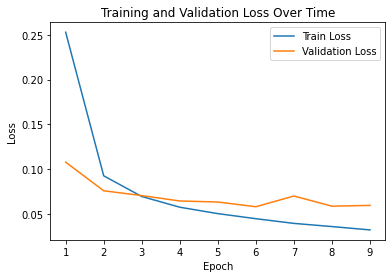

In [3]:
# Instantiate the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with early stopping on the GPU
num_epochs = 20 # Maximum
patience = 3
train_losses, val_losses = train_model(model, train_loader, criterion, optimizer, num_epochs, patience)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Time')
plt.show()

## Hyper parameter tuning

Until now, we have set different hyperparameters, like the learning rate, manually. But how did we choose this value? Could we have done better? Indeed, we could. We could have optimised the hyperparameter. In a nutshell, we can have repeat the analysis with different values for the hyperparameters and choose the hyperparameter combination that works best. For a neural network, we might be interested in tuning the learning rate and  changing a network layer size, i.e., adapting aspects of the architecture (see [here](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)). 

Of course, training a neural network many times to optimise the hyperparameters takes time. To keep things simple and start out with some code that runs quickly to get a better feeling of the basic concepts of hyperparameter tuning, let's start out with a simpler model. As discussed in notebook 1.3, you can also use PyTorch for linear fits, and these models train fast.

If you want to perform scalable hyperparameter tuning, [RayTune](https://docs.ray.io/en/latest/tune/index.html) is a popular option for Deep Learning. Moreover, you can use gridsearch cross validation and similar algorithms, e.g., from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). To get a better understanding of what happens, however, let's write parts of one of these algorithms ourselves.

In [4]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import KFold
import numpy as np

# PyTorch Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Generate synthetic data
torch.manual_seed(42)
X = 5 * torch.randn(100, 1)
y = 2 * X + 1 + 1.5 * torch.randn(100, 1)

# Convert data to NumPy arrays
X_np, y_np = X.numpy(), y.numpy()

# Convert data to PyTorch tensors
X_tensor, y_tensor = torch.tensor(X_np, dtype=torch.float32), torch.tensor(y_np, dtype=torch.float32)

# Number of epochs (you can experiment with this)
num_epochs = 100

# Initialize the linear regression model
model = LinearRegressionModel()

# Loss function
criterion = nn.MSELoss()

Here, we just want to optimise a single hyperparameter, the learning rate. If you were to optimise several hyperparameters, you would have to do so _in tandem_, i.e., you _cannot_ optimise one hyperparameter then keep it fixed and then optimise another hyperparameter, you have to do all of them at the same time.

In [5]:
# Hyperparameter search space (learning rates to try)
learning_rates = [1e-4, 1e-3, 1e-2]

To make better use of the data set, we split it into $k=5$ folds. We then repeat the training for each hyperparameter value $k=5$ times, using $k-1=4$ folds for training, while we withhold the last fold for validation. This approach helps assess model performance on various subsets of the data, mitigating the impact of a specific split, reducing the risk of overfitting to a single training-validation split. You can find a detailed explanation of k-fold cross validation on [scikit-learn's homepage](https://scikit-learn.org/stable/modules/cross_validation.html), where you will find the following illustration of the concept.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png">

For each iteration of the cross validation, we need to define folds and learning rates before training. Hence, the training loop is wrapped in two other loops defining the learning rate and the training/validation data sets. 

In [6]:
# Number of folds for cross-validation
num_folds = 5

# Perform k-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_lr = None
best_loss = float('inf')

# Now we lopp over the learning rates.
for lr in learning_rates:
    # Initialize the model for each learning rate
    model = LinearRegressionModel()

    all_val_losses = []
    # Training loop with cross-validation
    for train_indices, val_indices in kf.split(X_np):
        # For each iteration of the loop, we define a training set based on 4 folds
        X_train, y_train = X_np[train_indices], y_np[train_indices]
        # And create a validation set based on the remaining fold
        X_val, y_val = X_np[val_indices], y_np[val_indices]

        # Since our data are numpy arrays, we need to turn them into tensors.
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                      torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                    torch.tensor(y_val, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # We reset the learning rate in the optimiser
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        # Now we are ready for training
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # We go through the batches in the validation set
        val_losses = []
        for inputs, labels in val_loader:
            model.eval()
            with torch.no_grad():
                val_loss = criterion(model(inputs), labels)
            val_losses.append(val_loss.item())

        # Average validation loss for the current fold
        avg_val_loss_fold = sum(val_losses) / len(val_losses)
        all_val_losses.append(avg_val_loss_fold)

    # Average validation loss for present lr
    avg_val_loss = sum(all_val_losses) / len(all_val_losses)

    # Update the best learning rate if necessary
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_lr = lr

# Print the best learning rate
print("Best Learning Rate:", best_lr)

Best Learning Rate: 0.001


Now, you have found the best value of the learning rate. But you are not done yet. While you have trained a model using the best learning rate, you trained this model using cross validation, i.e., the model didn't see the whole data set during training.... So, you should retrain the model.

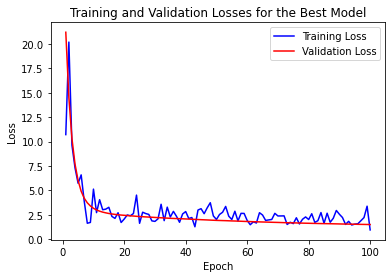

In [7]:
# Train the model with the best learning rate on the full training set
best_model = LinearRegressionModel()
best_optimizer = torch.optim.SGD(best_model.parameters(), lr=best_lr)

best_train_losses = []
best_val_losses = []

for epoch in range(num_epochs):
    best_model.train()
    for inputs, labels in train_loader:
        best_optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()

    # Training loss
    best_train_loss = loss.item()
    best_train_losses.append(best_train_loss)

    # Validation
    best_model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(best_model(inputs), labels) for inputs, labels in val_loader) / len(val_loader)
    best_val_losses.append(val_loss.item())

# Plot training and validation losses for the best model
plt.plot(range(1, num_epochs + 1), best_train_losses, label='Training Loss', color='b')
plt.plot(range(1, num_epochs + 1), best_val_losses, label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for the Best Model')
plt.legend()
plt.show()

## Exercises


**Exercise 1**: Discuss the novel aspects in the code above.

**Exercise 2**: Explain how you have to change the code for cross validation if we add a second hyperparameter that we want to optimise.

**Exercise 3**: Why is cross-validation important in hyperparameter optimization?